In [3]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

2024-04-10 03:32:57.224567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 03:32:57.224708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 03:32:57.368726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

data analysis

In [5]:
import os

def get_data():
    return pd.read_csv('../input/deepfake-faces/metadata.csv')

In [6]:
meta=get_data()
meta.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [5]:
meta.shape


(95634, 5)

In [7]:
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])


(79341, 16293)

In [8]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 8000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])
#we use here only 16000 images

In [9]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

In [10]:
Train_set.shape,Val_set.shape,Test_set.shape


((8960, 5), (3840, 5), (3200, 5))

In [11]:
#visualize the distribution of REAL & FAKE in training,validation,test sets through bar chart
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='blue'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='yellow'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)


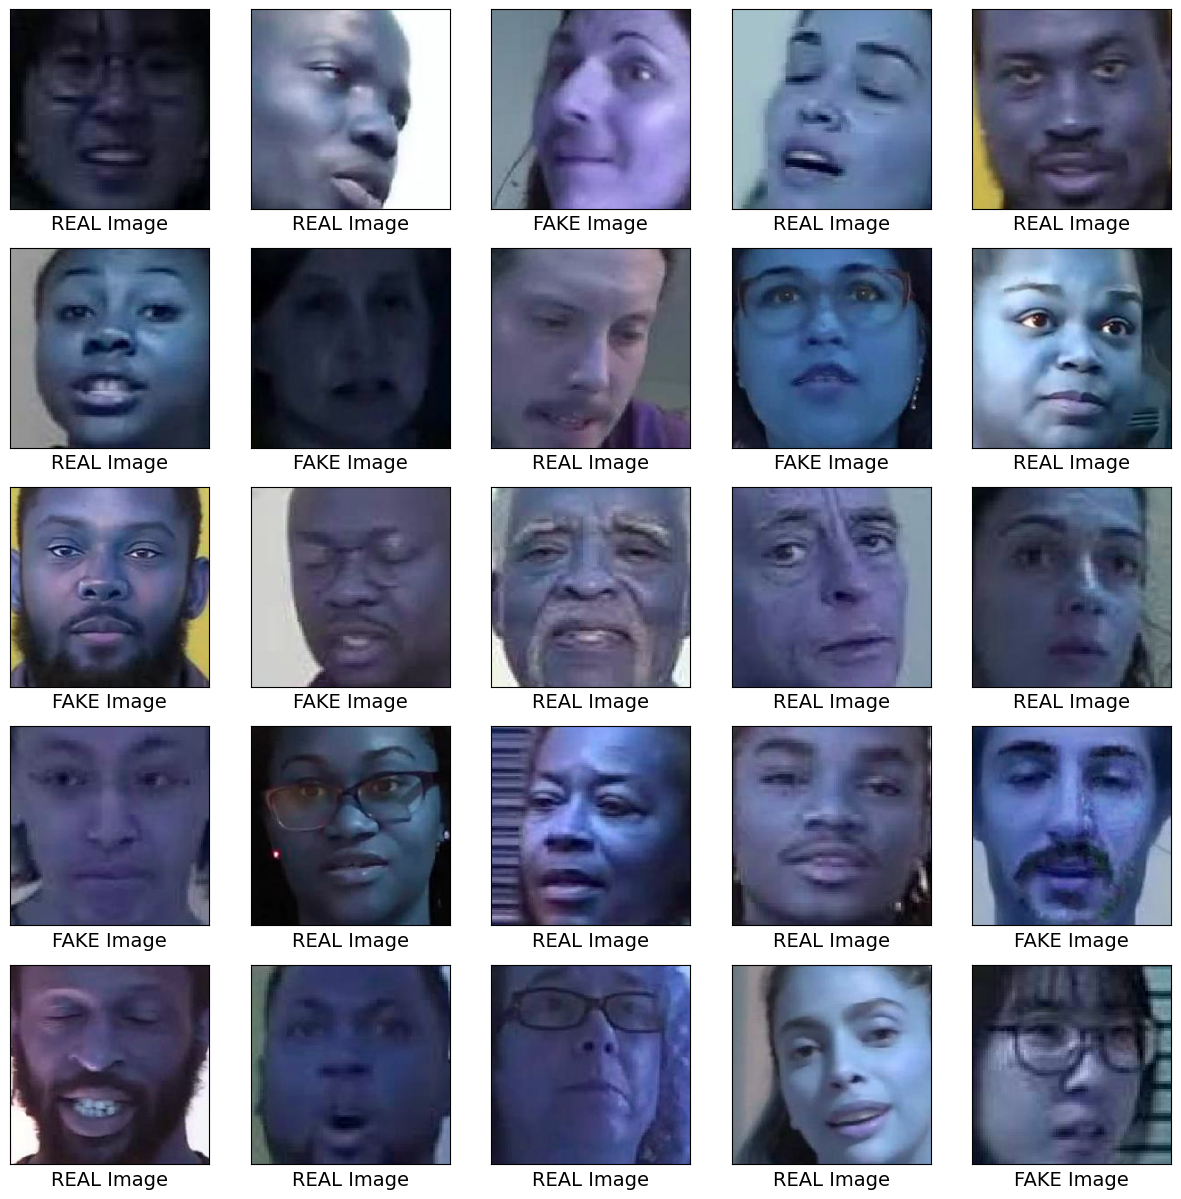

In [11]:
#recognises a set of images as REAL or Fake from training data 
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread('../input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

custom cnn architecture

In [12]:
#preprocesses a dataset: loads images, converts labels to numerical format and storing in numoy array
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels) #convert to numpy arrays as more effective 

In [13]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [14]:
#defines the structure of CNN for binary classification: REAL or FAKE
from functools import partial

tf.random.set_seed(42) 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [15]:
from functools import partial
import tensorflow as tf

tf.random.set_seed(42) 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[224, 224, 3]),  # Use Input layer with shape
    DefaultConv2D(filters=64, kernel_size=7),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [16]:
#binary cross entropy measures the difference between predicted and actual outputs
#nadam is an algorithm which updates the model's internal parameters to reduce loss

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    51,380,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,619,585 (196.91 MB)

 Trainable params: 51,619,585 (196.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = model.fit(X_train, y_train, epochs=5,batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2406s 17s/step - accuracy: 0.4975 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2371s 17s/step - accuracy: 0.4920 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2366s 17s/step - accuracy: 0.4920 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2242s 16s/step - accuracy: 0.4920 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4919 - loss: nan 

In [17]:
model.save('my_model.keras')


In [20]:
score = model.evaluate(X_test, y_test)


100/100 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.4805 - loss: 49.6411


In [21]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

100/100 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step


In [22]:
y_pred_binary = (y_pred > 0.5).astype(int)

In [23]:
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy}')

Accuracy: 0.4946875


In [24]:
f1 = f1_score(y_test, y_pred_binary)
print(f'F1 Score: {f1}')

F1 Score: 0.026490066225165563


In [25]:
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[1561   39]
 [1578   22]]


In [26]:
pip install seaborn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Note: you may need to restart the kernel to use updated packages.


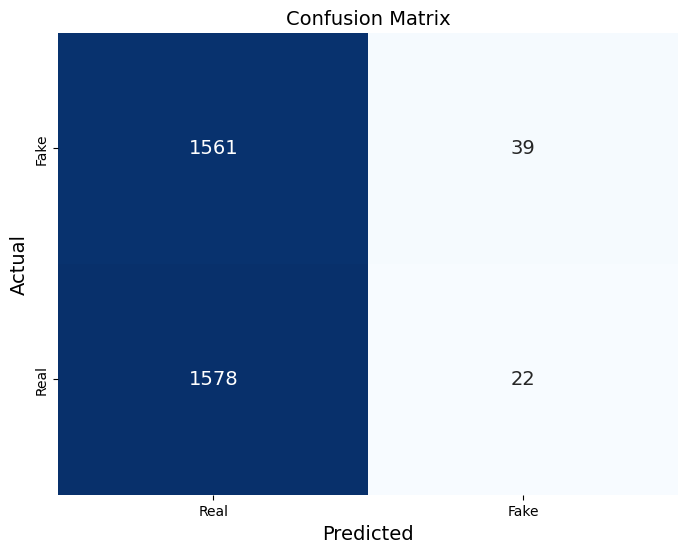

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Real', 'Fake'],
            yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


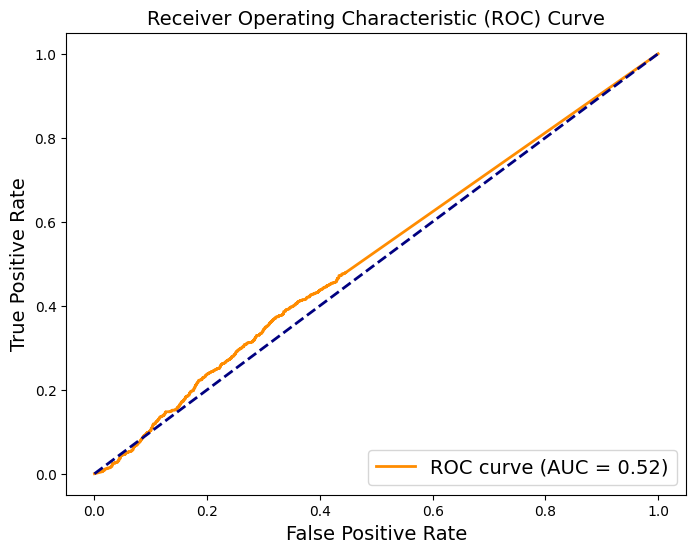

In [28]:
#roc curve shows the performance of a binary classification model
#FPR: proportion of actual negative cases incorrectly identified as positive
#TPR: proportion of actual positive cases correctly identified as positive
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [29]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and y_pred are defined
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Print TPR and FPR values
for i, (fpr_value, tpr_value) in enumerate(zip(fpr, tpr)):
    print(f'Threshold: {thresholds[i]:.4f}, FPR: {fpr_value:.4f}, TPR: {tpr_value:.4f}')

Threshold: 2.0000, FPR: 0.0000, TPR: 0.0000
Threshold: 1.0000, FPR: 0.0144, TPR: 0.0050
Threshold: 1.0000, FPR: 0.0144, TPR: 0.0063
Threshold: 1.0000, FPR: 0.0150, TPR: 0.0063
Threshold: 1.0000, FPR: 0.0150, TPR: 0.0069
Threshold: 1.0000, FPR: 0.0163, TPR: 0.0069
Threshold: 1.0000, FPR: 0.0163, TPR: 0.0075
Threshold: 1.0000, FPR: 0.0175, TPR: 0.0075
Threshold: 0.9992, FPR: 0.0175, TPR: 0.0100
Threshold: 0.9987, FPR: 0.0187, TPR: 0.0100
Threshold: 0.9983, FPR: 0.0187, TPR: 0.0106
Threshold: 0.9967, FPR: 0.0194, TPR: 0.0106
Threshold: 0.9903, FPR: 0.0194, TPR: 0.0119
Threshold: 0.9478, FPR: 0.0225, TPR: 0.0119
Threshold: 0.9378, FPR: 0.0225, TPR: 0.0125
Threshold: 0.9229, FPR: 0.0231, TPR: 0.0125
Threshold: 0.8458, FPR: 0.0231, TPR: 0.0138
Threshold: 0.2660, FPR: 0.0269, TPR: 0.0138
Threshold: 0.2565, FPR: 0.0269, TPR: 0.0144
Threshold: 0.2096, FPR: 0.0281, TPR: 0.0144
Threshold: 0.1718, FPR: 0.0281, TPR: 0.0156
Threshold: 0.1632, FPR: 0.0288, TPR: 0.0156
Threshold: 0.1496, FPR: 0.0288, 

In [42]:
#plot model performance
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.show()

NameError: name 'hist' is not defined

pre trained models

In [31]:
#preparing data
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [32]:
#Xception is a CNN 71 layers deep
#prepares train,validation and test data for training a CNN using Xception model's preprocessing
tf.keras.backend.clear_session()
batch_size=32 #no of samples processed by model in one iteration
preprocess=tf.keras.applications.xception.preprocess_input
train_set=train_set_raw.map(lambda X,y:(preprocess(tf.cast(X,tf.float32)),y))
train_set=train_set.shuffle(1000,seed=42).batch(batch_size).prefetch(1)
valid_set=valid_set_raw.map(lambda X,y:(preprocess(tf.cast(X,tf.float32)),y)).batch(batch_size)
test_set=test_set_raw.map(lambda X,y:(preprocess(tf.cast(X,tf.float32)),)).batch(batch_size)

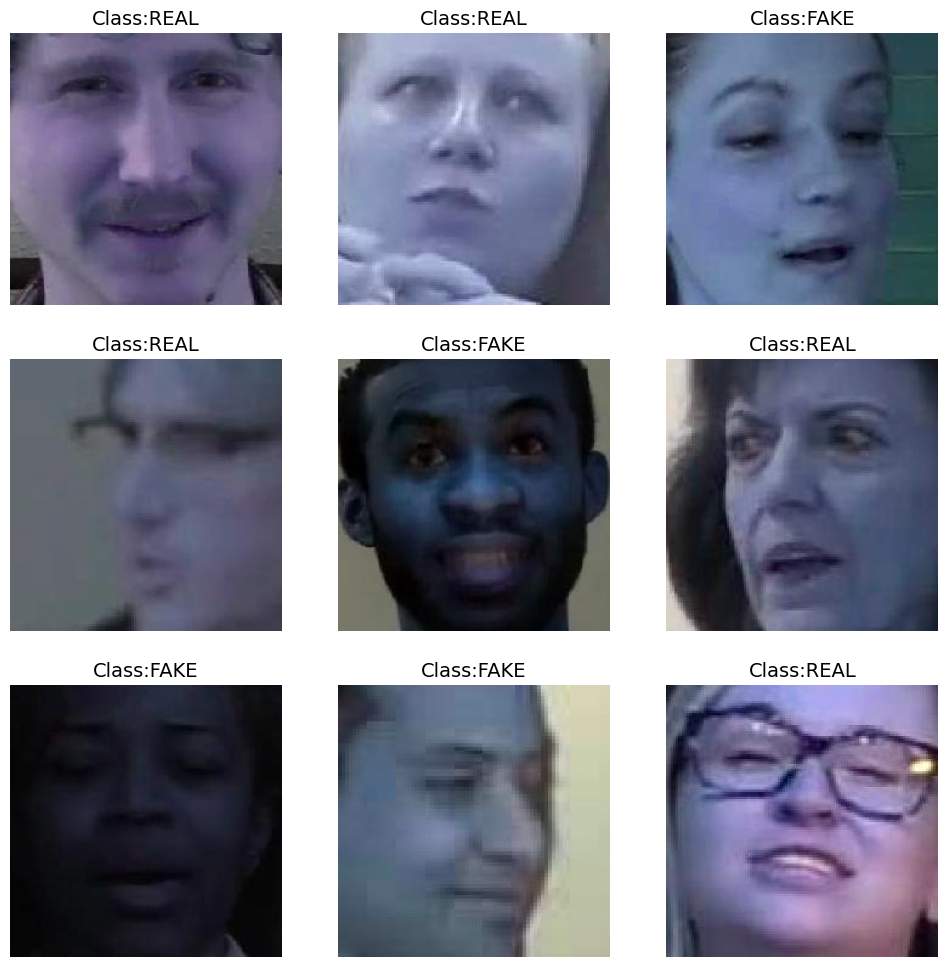

In [33]:
#displaying the first 9 images in the validation set
plt.figure(figsize=(12,12))
for X_batch,y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3,3,index+1)
        plt.imshow((X_batch[index]+1)/2)
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class:{classt}")
        plt.axis('off')
        
plt.show()

In [34]:
#helps the model learn features which are less specific sensitive to specific orientation
data_augmt=tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal',seed=42),
    tf.keras.layers.RandomRotation(factor=0.05,seed=42),
    tf.keras.layers.RandomContrast(factor=0.2,seed=42),
])

loading the pretrained model without its top layers

In [35]:
base_model = tf.keras.applications.Xception(weights=None, include_top=False)
base_model.load_weights("/kaggle/input/xception-weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [36]:
for layer in base_model.layers:
    layer.trainable=False

In [48]:
optim=tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9)
model.compile(loss='binary_crossentropy',optimizer=optim,metrics=['accuracy'])
his=model.fit(train_set,validation_data=valid_set,epochs=3)

Epoch 1/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 2482s 9s/step - accuracy: 0.4999 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 2490s 9s/step - accuracy: 0.5083 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 2468s 9s/step - accuracy: 0.5053 - loss: nan - val_accuracy: 0.5000 - val_loss: nan


In [37]:
for i in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for ix in i:  # ix is defined here
        print(f"{ix:3},", end='')
        layer_name = base_model.layers[ix].name
        truncated_name = layer_name[22:] if len(layer_name) > 22 else layer_name
        print(truncated_name, end='')
    print()  # Newline after each outer loop iteration

  0,input_layer 33,block4_pool 66,block8_sepconv1_act 99,block11_sepconv2_act
  1,block1_conv1 34,batch_normalization_2 67,block8_sepconv1100,block11_sepconv2
  2,block1_conv1_bn 35,add_2 68,block8_sepconv1_bn101,block11_sepconv2_bn
  3,block1_conv1_act 36,block5_sepconv1_act 69,block8_sepconv2_act102,block11_sepconv3_act
  4,block1_conv2 37,block5_sepconv1 70,block8_sepconv2103,block11_sepconv3
  5,block1_conv2_bn 38,block5_sepconv1_bn 71,block8_sepconv2_bn104,block11_sepconv3_bn
  6,block1_conv2_act 39,block5_sepconv2_act 72,block8_sepconv3_act105,add_9
  7,block2_sepconv1 40,block5_sepconv2 73,block8_sepconv3106,block12_sepconv1_act
  8,block2_sepconv1_bn 41,block5_sepconv2_bn 74,block8_sepconv3_bn107,block12_sepconv1
  9,block2_sepconv2_act 42,block5_sepconv3_act 75,add_6108,block12_sepconv1_bn
 10,block2_sepconv2 43,block5_sepconv3 76,block9_sepconv1_act109,block12_sepconv2_act
 11,block2_sepconv2_bn 44,block5_sepconv3_bn 77,block9_sepconv1110,block12_sepconv2
 12,conv2d 45,add_3 

In [55]:
model.save('my_model.h5')

using the new top layers to make it train which would have lower learning rate 

In [38]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
his = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 2311s 8s/step - accuracy: 0.4985 - loss: 0.9953 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 2406s 8s/step - accuracy: 0.5007 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 2291s 8s/step - accuracy: 0.4921 - loss: 0.6936 - val_accuracy: 0.4919 - val_loss: 0.6934


In [39]:
model.save('xception_deepfake_image.h5')

In [40]:
#plot performance
acc=history.hist['accuracy']
val_acc=history.hist['val_accuracy']
loss=history.hist['loss']
val_loss=history.hist['val_loss']
epoch_rang=range(1,len(his.epoch)+1)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(epoch_rang,acc,label='Train set')
plt.plot(epoch_rang,val_acc,label='Val set')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model accuracy')

plt.subplot(1,2,2)
plt.plot(epoch_rang,loss,label='Train set')
plt.plot(epoch_rang,val_acc,label='Val set')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.show()

NameError: name 'history' is not defined

In [ ]:
model.evaluate(test_set)

In [ ]:
#evaluation on test set
y_pred_probs=model.predict(test_set)
#convert tensorflow tensors to numpy array 
y_true_list=[y.numpy() for _,y in test_set_raw]

y_true=np.hstack(y_true_list)

#probabilites to binary predictions
y_pred_bin=(y_pred_probs>0.5).astype(int)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#confusion matrix
conf_matrix=confusion_matrix(y_true,y_pred_bin)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=['Negative','Positive'],yticklabels
           =['Negative','Positive'])
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()

In [30]:
#roc curve
fpr,tpr,thresholds=roc_curve(y_true,y_pred_probs)
roc_auc=auc(fpr,tpr)

import matplotlib.plyplot as plt
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='blue',lw=2,label=f'ROC curve(AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],color='pink',lw=2,linestyle='--')
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

NameError: name 'y_true' is not defined

model accuracy is 81.9%